<a href="https://colab.research.google.com/github/Janhvi-S103/PixelSense-AI/blob/main/PixelSense_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Smart Pixelator...
Please upload your image(s) when prompted...


Saving pexels-anjana-c-169994-674010.jpg to pexels-anjana-c-169994-674010.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]



Processing pexels-anjana-c-169994-674010.jpg...


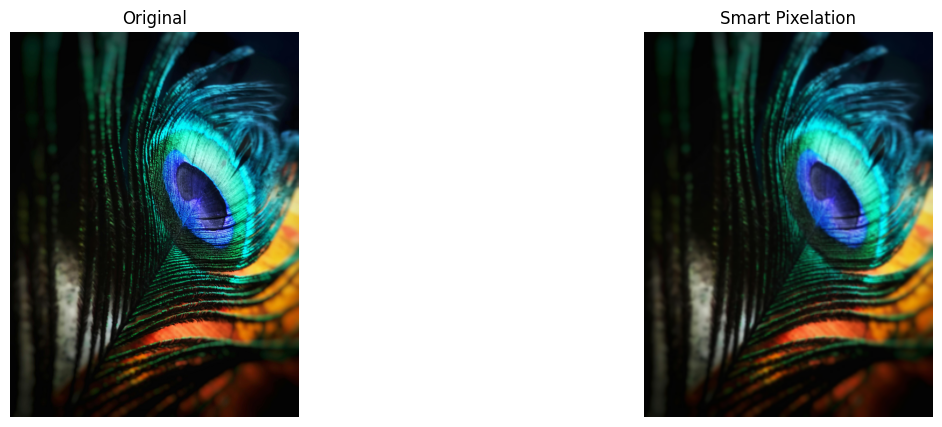

Saved as pexels-anjana-c-169994-674010_smart_pixelated.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from google.colab import files
import io
import os
import matplotlib.pyplot as plt
from torchvision.models import resnet18

class AdaptivePixelationNetwork(nn.Module):
    def __init__(self):
        super(AdaptivePixelationNetwork, self).__init__()

        # Use pretrained ResNet18 as feature extractor
        resnet = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        # Importance map generator
        self.importance_decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)

        # Generate importance map
        importance_map = self.importance_decoder(features)

        # Ensure importance map matches input size
        importance_map = nn.functional.interpolate(
            importance_map,
            size=(x.shape[2], x.shape[3]),
            mode='bilinear',
            align_corners=False
        )

        return importance_map

class AdaptivePixelator:
    def __init__(self, base_pixel_size=8, device=None):
        self.base_pixel_size = base_pixel_size
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        self.model = AdaptivePixelationNetwork().to(self.device)
        self.model.eval()

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def apply_adaptive_pixelation(self, image, importance_map):
        """Apply pixelation with varying intensity based on importance map"""
        # Convert to numpy for processing
        img_np = np.array(image)
        importance_map = importance_map.squeeze().cpu().numpy()

        # Resize importance map to match image
        importance_map = Image.fromarray((importance_map * 255).astype(np.uint8))
        importance_map = importance_map.resize(image.size, Image.BILINEAR)
        importance_map = np.array(importance_map) / 255.0

        # Create output image
        output = np.zeros_like(img_np)
        height, width = img_np.shape[:2]

        # Apply adaptive pixelation
        for y in range(0, height, self.base_pixel_size):
            for x in range(0, width, self.base_pixel_size):
                # Get region importance
                region_importance = importance_map[y:y+self.base_pixel_size,
                                                x:x+self.base_pixel_size].mean()

                # Calculate adaptive pixel size
                pixel_size = int(self.base_pixel_size * (1 + (1 - region_importance) * 2))

                # Get region bounds
                y_end = min(y + pixel_size, height)
                x_end = min(x + pixel_size, width)

                # Apply pixelation to region
                region = img_np[y:y_end, x:x_end]
                if region.size > 0:
                    color = region.mean(axis=(0, 1))
                    output[y:y_end, x:x_end] = color

        return Image.fromarray(output.astype(np.uint8))

    def pixelate_image(self, image_data):
        """Process image with adaptive pixelation"""
        try:
            # Load and prepare image
            original_image = Image.open(io.BytesIO(image_data)).convert('RGB')
            input_tensor = self.transform(original_image).unsqueeze(0).to(self.device)

            # Generate importance map
            with torch.no_grad():
                importance_map = self.model(input_tensor)

            # Apply adaptive pixelation
            pixelated_image = self.apply_adaptive_pixelation(original_image, importance_map)

            return pixelated_image, original_image

        except Exception as e:
            print(f"Error processing image: {str(e)}")
            raise

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """Training function for the model"""
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (images, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

def process_images(pixel_size=8):
    """Process uploaded images with the smart pixelator"""
    print("Please upload your image(s) when prompted...")
    uploaded = files.upload()

    if not uploaded:
        print("No files were uploaded.")
        return

    pixelator = AdaptivePixelator(base_pixel_size=pixel_size)

    for filename, data in uploaded.items():
        print(f"\nProcessing {filename}...")
        try:
            pixelated_image, original_image = pixelator.pixelate_image(data)

            # Display results
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(original_image)
            plt.title("Original")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(pixelated_image)
            plt.title("Smart Pixelation")
            plt.axis('off')

            plt.show()

            # Save result
            output_filename = f"{os.path.splitext(filename)[0]}_smart_pixelated.png"
            pixelated_image.save(output_filename)
            print(f"Saved as {output_filename}")
            files.download(output_filename)

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

if __name__ == "__main__":
    print("Starting Smart Pixelator...")
    process_images(pixel_size=12)

Starting Smart Pixelator...
Enter pixelation intensity (0-100): 60
Using pixelation intensity: 60.0/100
Please upload your image(s) when prompted...


Saving pexels-anjana-c-169994-674010.jpg to pexels-anjana-c-169994-674010 (2).jpg

Processing pexels-anjana-c-169994-674010 (2).jpg...


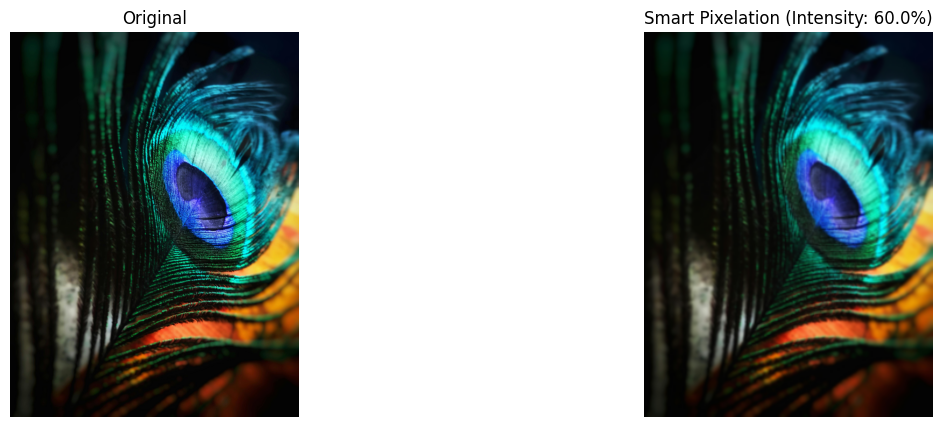

Saved as pexels-anjana-c-169994-674010 (2)_pixelated_60.0.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from google.colab import files
import io
import os
import matplotlib.pyplot as plt
from torchvision.models import resnet18

class AdaptivePixelationNetwork(nn.Module):
    def __init__(self):
        super(AdaptivePixelationNetwork, self).__init__()

        # Use pretrained ResNet18 as feature extractor
        resnet = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        # Importance map generator
        self.importance_decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        importance_map = self.importance_decoder(features)
        importance_map = nn.functional.interpolate(
            importance_map,
            size=(x.shape[2], x.shape[3]),
            mode='bilinear',
            align_corners=False
        )
        return importance_map

class AdaptivePixelator:
    def __init__(self, base_pixel_size=8, intensity=50, device=None):
        self.base_pixel_size = base_pixel_size
        self.intensity = max(0, min(100, intensity))  # Clamp between 0-100
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        self.model = AdaptivePixelationNetwork().to(self.device)
        self.model.eval()

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def apply_adaptive_pixelation(self, image, importance_map):
        """Apply pixelation with varying intensity based on importance map and user-defined intensity"""
        img_np = np.array(image)
        importance_map = importance_map.squeeze().cpu().numpy()

        # Resize importance map to match image
        importance_map = Image.fromarray((importance_map * 255).astype(np.uint8))
        importance_map = importance_map.resize(image.size, Image.BILINEAR)
        importance_map = np.array(importance_map) / 255.0

        # Scale importance map based on user intensity
        intensity_factor = self.intensity / 50.0  # Convert 0-100 scale to scaling factor

        output = np.zeros_like(img_np)
        height, width = img_np.shape[:2]

        for y in range(0, height, self.base_pixel_size):
            for x in range(0, width, self.base_pixel_size):
                region_importance = importance_map[y:y+self.base_pixel_size,
                                                x:x+self.base_pixel_size].mean()

                # Adjust pixel size based on importance and user intensity
                pixel_size = int(self.base_pixel_size * (1 + (1 - region_importance) * 2 * intensity_factor))

                y_end = min(y + pixel_size, height)
                x_end = min(x + pixel_size, width)

                region = img_np[y:y_end, x:x_end]
                if region.size > 0:
                    color = region.mean(axis=(0, 1))
                    output[y:y_end, x:x_end] = color

        return Image.fromarray(output.astype(np.uint8))

    def pixelate_image(self, image_data):
        """Process image with adaptive pixelation"""
        try:
            original_image = Image.open(io.BytesIO(image_data)).convert('RGB')
            input_tensor = self.transform(original_image).unsqueeze(0).to(self.device)

            with torch.no_grad():
                importance_map = self.model(input_tensor)

            pixelated_image = self.apply_adaptive_pixelation(original_image, importance_map)

            return pixelated_image, original_image

        except Exception as e:
            print(f"Error processing image: {str(e)}")
            raise

def process_images(pixel_size=8, intensity=50):
    """Process uploaded images with the smart pixelator"""
    print(f"Using pixelation intensity: {intensity}/100")
    print("Please upload your image(s) when prompted...")
    uploaded = files.upload()

    if not uploaded:
        print("No files were uploaded.")
        return

    pixelator = AdaptivePixelator(base_pixel_size=pixel_size, intensity=intensity)

    for filename, data in uploaded.items():
        print(f"\nProcessing {filename}...")
        try:
            pixelated_image, original_image = pixelator.pixelate_image(data)

            # Display results
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(original_image)
            plt.title("Original")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(pixelated_image)
            plt.title(f"Smart Pixelation (Intensity: {intensity}%)")
            plt.axis('off')

            plt.show()

            output_filename = f"{os.path.splitext(filename)[0]}_pixelated_{intensity}.png"
            pixelated_image.save(output_filename)
            print(f"Saved as {output_filename}")
            files.download(output_filename)

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

if __name__ == "__main__":
    print("Starting Smart Pixelator...")
    # Get user input for intensity
    while True:
        try:
            intensity = float(input("Enter pixelation intensity (0-100): "))
            if 0 <= intensity <= 100:
                break
            print("Please enter a value between 0 and 100.")
        except ValueError:
            print("Please enter a valid number.")

    process_images(pixel_size=12, intensity=intensity)